# Notes:

1. Extract data from Port Buffer (Do not re-run)
2. Create Routes p1
3. <b>Create Routes p2 and Validate Vessel Information</b>
4. Update Departures Draught Info Update Departures Draught Info
5. Extract to Local
6. Trade Estimation (Local)

Set-up: UNGP - kernel `ais-tt-dev`

From the 2nd notebook, there may be routes that are quick because of small movements by vessels located at the edges of the boundaries. To remove the noise, we say that a vessel has fully exited the port when it spends at least 1 day outside of Port Boundary. Otherwise, we treat consecutive routes within 24 hours of each other as one. We then combine the routes data with Ship Registry data to get the finer vessel categories and other information on the vessel required for trade estimation. The matching is done using both MMSI and IMO numbers from both data sources. We validate the match by comparing the vessel names. 

The routes are also refined further to get only
1. routes from individual vessels based on MMSI
2. routes containing more than 1 AIS signal to address data quality issue during early 2020

# Initializers

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np

In [3]:
pd.set_option('display.max_columns', None) #Show all columns in pandas df
pd.set_option('display.max_rows', 100) #Show 100 rows in pandas df
pd.options.display.float_format = '{:.10f}'.format #Show float with 10 decimal points in pandas df

from IPython.core.interactiveshell import InteractiveShell #allow multiple outputs in one jupyter cell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
#name comparison
!pip install nltk

Error while sending or receiving.
Traceback (most recent call last):
  File "/opt/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 503, in send_command
    self.socket.sendall(command.encode("utf-8"))
ConnectionResetError: [Errno 104] Connection reset by peer
Closing down clientserver connection
Exception while sending command.
Traceback (most recent call last):
  File "/opt/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 503, in send_command
    self.socket.sendall(command.encode("utf-8"))
ConnectionResetError: [Errno 104] Connection reset by peer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/opt/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 506, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetwor

In [5]:
#for comparison of strings
import nltk

## Variables

In [90]:
bucket = 'ungp-ais-data-historical-backup'
s3path = "s3a://ungp-ais-data-historical-backup/user_temp/"

wb_path = f"{s3path}worldbank/"

path_lbn = f"{wb_path}lebanon/"
path_port_calls = f"{wb_path}lebanon_port_calls/"

ihs_basepath = "s3a://ungp-ais-data-historical-backup/register/"
ihs_basepath_archive = "s3a://ungp-ais-data-historical-backup/register-archive/"

# Routes

In [8]:
sdf = spark.read.option("basePath",path_lbn).parquet(path_lbn)

In [9]:
df = sdf.toPandas()

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [33]:
len(df)

53012

In [34]:
df.head(2)

,mmsi,route_group,polygon_name,imo,flag_country,vessel_name,vessel_type,vessel_type_main,vessel_type_sub,arrival_dt_pos_utc,arrival_draught,arrival_destination,arrival_length,arrival_width,arrival_heading,count_ais,max_draught,min_draught,mean_draught,max_sog,min_sog,mean_sog,departure_dt_pos_utc,departure_draught,departure_destination,departure_length,departure_width,departure_heading,year,month,width,length,Port,Country,date
0,214180912.0000000000,2,Tarabulus Buffer,7341702.0000000000,Moldova,ALI K,Cargo,Bulk Carrier,None,2020-10-10 15:40:18,7.3000000000,TRIPOLI,102.0000000000,15.0000000000,0.0000000000,7.0000000000,7.3000000000,7.3000000000,7.3000000000,9.1000000000,0.0000000000,6.3142857143,2020-10-10 16:07:31,7.3000000000,TRIPOLI,102.0000000000,15.0000000000,0.0000000000,2020.0000000000,10.0000000000,15.0000000000,102.0000000000,Tarabulus Buffer,Lebanon,2020-10-10
1,214181902.0000000000,1,Tarabulus,9212773.0000000000,Moldova,SEA MUSIC,Cargo,General Cargo Ship,None,2020-10-15 04:54:07,0.0000000000,None,116.0000000000,18.0000000000,0.0000000000,109.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,2020-10-16 14:36:47,0.0000000000,None,116.0000000000,18.0000000000,0.0000000000,2020.0000000000,10.0000000000,18.0000000000,116.0000000000,Tarabulus,Lebanon,2020-10-15


In [35]:
df.loc[:, "width"] = df.loc[:, "departure_width"]
df.loc[:, "length"] = df.loc[:, "departure_length"]
df.loc[:, "Port"] = df.loc[:, "polygon_name"]
df.loc[:, "Country"] = "Lebanon"

In [36]:
# df = pd.concat([pd.read_pickle(f"{path_route}{country}/{year}.pkl") for year in [2019,2020,2021,2022,2023] for country in country_list], ignore_index=True)
# df.info()

In [37]:
# df.Country.unique()

In [38]:
# df[df['Country Buffer'] != df['Country']]

In [39]:
# df.groupby(['Country','Port']).size()

In [40]:
#Keep only routes within the IMF boundary
#NOTE REASSIGNMENT OF VARIABLE

# df = df[~df['Country'].isnull()].copy()

In [41]:
df.shape

(53012, 35)

In [42]:
df['date'] = df['arrival_dt_pos_utc'].dt.floor('d')

From Samoa notebook

## Route aggregation

In [43]:
def agg_per_group(df_, group_col, ship_col):
    """
    Aggregates pre-defined columns from a pandas dataframe based on supplied unique identifiers
    
    group_col: list of columns for unique identifier of routes
    ship_col: list of columns for unique identifier of ships


    returns: Dataframe with aggregated columns
    
    gets the first occurence by group_col
                                
    get the last occurence by group_col
                
    get summary statistics according to aggregation function by group_col
    
    time_travel = time difference between previous route departre_dt_pos_utc and current route arrival_dt_pos_utc
    sorting according to ship_col 
    
    """
    df = df_.sort_values(group_col + ['arrival_dt_pos_utc'],ignore_index=True)
    
    df['tot_sog'] = df['mean_sog'] * df['count_ais']

    df_agg = df.groupby(group_col, dropna=False).agg({x:'first' for x in ["length","width","vessel_type",
                                                            "arrival_dt_pos_utc","arrival_draught","arrival_destination"
                                                            ]
                                       }).join(df.groupby(group_col, dropna=False).agg({'count_ais':'sum',
                                                                          'tot_sog':'sum',
                                                                          'max_sog':'max',
                                                                          'min_sog':'min'})
                                              ).join(df.groupby(group_col, dropna=False).agg({x:'last' for x in ['departure_dt_pos_utc','departure_draught','departure_destination',
                                                                                                  ]}))
        
    df_agg['mean_sog'] = df_agg['tot_sog'] / df_agg['count_ais']

    df_agg['time_spent'] = df_agg['departure_dt_pos_utc'] - df_agg['arrival_dt_pos_utc']
    
    df_agg = df_agg.drop(columns=['tot_sog']).reset_index()
    
    df_agg.sort_values(ship_col + ['arrival_dt_pos_utc'], inplace=True, ignore_index=True)
    df_agg['prev_departure_dt_pos_utc'] = df_agg.groupby(ship_col)['departure_dt_pos_utc'].shift(1)
    df_agg['time_travel'] = df_agg['arrival_dt_pos_utc'] - df_agg['prev_departure_dt_pos_utc']
    
    df_agg['year'] = df_agg['arrival_dt_pos_utc'].dt.year
    df_agg['month'] = df_agg['arrival_dt_pos_utc'].dt.month
    df_agg['date'] = df_agg['arrival_dt_pos_utc'].dt.floor('d')
   
    
    return df_agg

In [44]:
df.polygon_name.unique()

array(['Tarabulus Buffer', 'Tarabulus', 'Bayrut Buffer', 'Bayrut',
       'Sayda Buffer', 'Sayda'], dtype=object)

In [45]:
ports = ['Tarabulus', 'Bayrut', 'Sayda']

In [46]:
df.columns

Index(['mmsi', 'route_group', 'polygon_name', 'imo', 'flag_country',
       'vessel_name', 'vessel_type', 'vessel_type_main', 'vessel_type_sub',
       'arrival_dt_pos_utc', 'arrival_draught', 'arrival_destination',
       'arrival_length', 'arrival_width', 'arrival_heading', 'count_ais',
       'max_draught', 'min_draught', 'mean_draught', 'max_sog', 'min_sog',
       'mean_sog', 'departure_dt_pos_utc', 'departure_draught',
       'departure_destination', 'departure_length', 'departure_width',
       'departure_heading', 'year', 'month', 'width', 'length', 'Port',
       'Country', 'date'],
      dtype='object')

In [51]:
## include only mmsi for individual ships: MIDxxxxxx, where MID from 200-799
## - https://en.wikipedia.org/wiki/Maritime_Mobile_Service_Identity#Station_Identity_Formats
cond = (df.mmsi >= 200000000) & (df.mmsi <= 799999999)

#keep only routes within ports
cond2 = df['polygon_name'].isin(ports)

#aggregate routes within the day into one
group_col = ["mmsi","imo","vessel_name","year","month","date","Port"]
ship_col = ["mmsi","imo","vessel_name"]
df_agg = agg_per_group(df[cond & cond2], group_col, ship_col)
 
print(f"""
Raw routes  --------
{df.groupby('year').agg({'route_group':'count','mmsi':'nunique'})}

Keep only routes within Apia -----
{df[cond2].groupby('year').agg({'route_group':'count','mmsi':'nunique'})}

Include only individual ships -----
{df[cond & cond2].groupby('year').agg({'route_group':'count','mmsi':'nunique'})}

Aggregate routes within the day ----
{df_agg.groupby('year').agg({'date':'count','mmsi':'nunique'})}
""")


Raw routes  --------
                 route_group  mmsi
year                              
2019.0000000000        13343  1320
2020.0000000000        13187  1277
2021.0000000000         9835   910
2022.0000000000         8130   939
2023.0000000000         8168  1127

Keep only routes within Apia -----
                 route_group  mmsi
year                              
2019.0000000000         5367  1060
2020.0000000000         5507  1021
2021.0000000000         4005   729
2022.0000000000         3462   739
2023.0000000000         3315   719

Include only individual ships -----
                 route_group  mmsi
year                              
2019.0000000000         5334  1051
2020.0000000000         5494  1013
2021.0000000000         3826   728
2022.0000000000         3462   739
2023.0000000000         3315   719

Aggregate routes within the day ----
      date  mmsi
year            
2019  4312  1051
2020  3933  1013
2021  3275   728
2022  2764   739
2023  2763   719



In [52]:
df_agg['time_travel_flag'] = np.where((df_agg.time_travel <= "1 days") & ~(df_agg.time_travel.isnull()), 0, 1)
df_agg['new_route_group'] = df_agg.groupby(ship_col).time_travel_flag.cumsum()

In [53]:
df_agg['time_travel_flag'] = np.where((df_agg.time_travel <= "1 days") & ~(df_agg.time_travel.isnull()), 0, 1)
df_agg['new_route_group'] = df_agg.groupby(ship_col).time_travel_flag.cumsum()

group_col = ["mmsi","imo","vessel_name", "new_route_group", "Port"]
df_agg = agg_per_group(df_agg, group_col, ship_col)


cond = df_agg.count_ais > 1
print(f"""
Aggregate routes where time in between is less than 1 day ----
{df_agg.groupby('year').agg({'new_route_group':'count','mmsi':'nunique'})}

Remove routes with only 1 AIS signal ----
{df_agg[cond].groupby('year').agg({'new_route_group':'count','mmsi':'nunique'})}

""")


Aggregate routes where time in between is less than 1 day ----
      new_route_group  mmsi
year                       
2019             2862  1051
2020             2523   957
2021             2206   667
2022             2150   715
2023             1948   687

Remove routes with only 1 AIS signal ----
      new_route_group  mmsi
year                       
2019             2730   960
2020             2338   790
2021             2076   652
2022             1990   676
2023             1860   666




In [55]:
# df_agg.head(3)

<Axes: title={'center': 'AIS Routes Raw'}, xlabel='arrival_dt_pos_utc'>

<Axes: title={'center': 'AIS Routes Raw'}, xlabel='arrival_dt_pos_utc'>

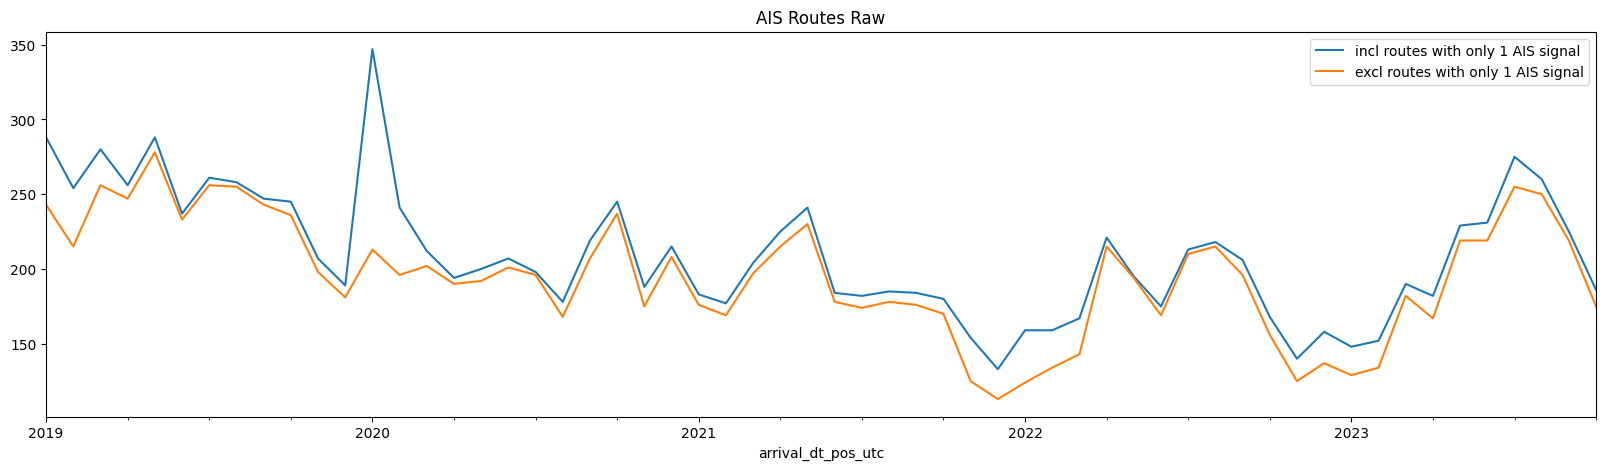

In [56]:
#Sketchy Jan 2020 data, fixed by removing routes with only 1 AIS signal
df_agg.set_index('arrival_dt_pos_utc').groupby(pd.Grouper(freq="M")).mmsi.count().rename("incl routes with only 1 AIS signal").plot(figsize=(20,5), title="AIS Routes Raw",
                                                                                                                                   legend=True)
df_agg[cond].set_index('arrival_dt_pos_utc').groupby(pd.Grouper(freq="M")).mmsi.count().rename("excl routes with only 1 AIS signal").plot(legend=True)

In [57]:
#warning reassign variable
df_agg = df_agg[cond].reset_index(drop=True)

In [58]:
print(f"""
We have reduced the routes data from {df.shape[0]:,} to {df_agg.shape[0]:,}.
""")


We have reduced the routes data from 53,012 to 11,294.



# Ship Register Data

In [59]:
#latest available version in ungp
ihs_version = pd.read_csv(ihs_basepath+"version.csv")
ihs_version

,20231030


In [60]:
#Check Column list
ihs_columns = pd.read_csv(ihs_basepath+"ShipData.CSV", nrows=2).columns.tolist()
ihs_columns

['LRIMOShipNo',
 'StatCode5',
 'AlterationsDescriptiveNarrative',
 'PropulsionTypeCode',
 'ShipName',
 'ExName',
 'MaritimeMobileServiceIdentityMMSINumber',
 'RegisteredOwnerCode',
 'RegisteredOwnerCountryOfRegistration',
 'RegisteredOwnerCountryofDomicile',
 'ShipManagerCompanyCode',
 'ShipManagerCountryOfRegistration',
 'ShipManagerCountryofDomicileName',
 'GroupBeneficialOwnerCompanyCode',
 'GroupBeneficialOwnerCountryOfRegistration',
 'GroupBeneficialOwnerCountryofDomicile',
 'OperatorCompanyCode',
 'OperatorCountryOfRegistration',
 'OperatorCountryofDomicileName',
 'FlagCode',
 'PortofRegistryCode',
 'Tonnagesystem69convention',
 'GrossTonnage',
 'Deadweight',
 'LengthOverallLOA',
 'LengthBetweenPerpendicularsLBP',
 'LengthRegistered',
 'DateOfBuild',
 'ShipbuilderCompanyCode',
 'YardNumber',
 'NumberofDecks',
 'HoldsDescriptiveNarrative',
 'TanksDescriptiveNarrative',
 'NumberofHatches',
 'NumberofHolds',
 'NumberofTanks',
 'InsulatedCapacity',
 'TEU',
 'NumberofMainEngines',
 'P

In [61]:
 # from ShipData (FACT Table) get only relevant columns
ihs = pd.read_csv(ihs_basepath+"ShipData.CSV", usecols=['StatCode5','LRIMOShipNo','MaritimeMobileServiceIdentityMMSINumber',
                                                        'ShipName','ExName','TEU',
                                                        'Draught','Deadweight','NetTonnage','GrossTonnage','Displacement','LightDisplacementTonnage',
                                                        'LengthOverallLOA','LengthRegistered','BreadthExtreme','BreadthMoulded'])


ihs.rename(columns={'MaritimeMobileServiceIdentityMMSINumber':'mmsi','LRIMOShipNo':'imo'}, inplace=True)

ihs.shape
#Big file, keep only where imo or mmsi is ins the ais data
ihs = ihs[ihs.imo.isin(df_agg.imo) | ihs.mmsi.isin(df_agg.mmsi)].reset_index(drop=True)

ihs.info()
ihs.head()

(254235, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2030 entries, 0 to 2029
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   imo                       2030 non-null   int64  
 1   StatCode5                 2030 non-null   object 
 2   ShipName                  2030 non-null   object 
 3   ExName                    1448 non-null   object 
 4   mmsi                      1910 non-null   float64
 5   GrossTonnage              2030 non-null   int64  
 6   Deadweight                2030 non-null   int64  
 7   LengthOverallLOA          2030 non-null   float64
 8   LengthRegistered          2030 non-null   float64
 9   TEU                       2030 non-null   int64  
 10  BreadthExtreme            2030 non-null   float64
 11  BreadthMoulded            2030 non-null   float64
 12  Displacement              2030 non-null   int64  
 13  Draught                   2030 non-null   float64
 14  LightDis

,imo,StatCode5,ShipName,ExName,mmsi,GrossTonnage,Deadweight,LengthOverallLOA,LengthRegistered,TEU,BreadthExtreme,BreadthMoulded,Displacement,Draught,LightDisplacementTonnage,NetTonnage
0,4517025,X11C2NF,INDEPENDENCIA,NaN,710455000.0000000000,0,0,129.2000000000,0.0000000000,0,0.0000000000,13.5000000000,3707,5.5000000000,0.0000000000,0
1,4517037,X11C2NF,UNIAO,NaN,710467000.0000000000,0,0,129.2000000000,0.0000000000,0,0.0000000000,13.5000000000,3707,5.5000000000,0.0000000000,0
2,4517049,X11C2NC,BARROSO,NaN,710450000.0000000000,0,0,103.4000000000,0.0000000000,0,0.0000000000,11.4000000000,2390,5.3000000000,0.0000000000,0
3,4536837,B34H2SQ,THESEAS,NaN,212264000.0000000000,100,0,27.6000000000,0.0000000000,0,0.0000000000,4.1000000000,0,0.3000000000,0.0000000000,0
4,4536849,B34H2SQ,ONISILOS,NaN,212305000.0000000000,100,0,27.6000000000,0.0000000000,0,0.0000000000,4.1000000000,0,0.3000000000,0.0000000000,0


In [62]:
# from Ship Type Code (Dimension Table) get only relevant columns
ihs_statcode = pd.read_csv(ihs_basepath + "tblShipTypeCodes.CSV", usecols=['StatCode5',
                                                                           'SubType',
                                                                           'SubGroup',
                                                                           'HullType',
                                                                           'ShiptypeLevel1',
                                                                           'ShipTypeLevel2',
                                                                           'ShipTypeLevel3',
                                                                           'ShipTypeLevel4',
                                                                           'ShiptypeLevel5'
                                                                          ]
                                                                           )

#Big file, keep only where imo or mmsi is ins the ais data
ihs_statcode = ihs_statcode[ihs_statcode['StatCode5'].isin(ihs.StatCode5)].reset_index(drop=True)

ihs_statcode.info()
ihs_statcode.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   StatCode5       47 non-null     object
 1   ShiptypeLevel5  47 non-null     object
 2   ShipTypeLevel4  47 non-null     object
 3   ShipTypeLevel3  47 non-null     object
 4   ShipTypeLevel2  47 non-null     object
 5   ShiptypeLevel1  47 non-null     object
 6   HullType        47 non-null     object
 7   SubGroup        47 non-null     object
 8   SubType         47 non-null     object
dtypes: object(9)
memory usage: 3.4+ KB


,StatCode5,ShiptypeLevel5,ShipTypeLevel4,ShipTypeLevel3,ShipTypeLevel2,ShiptypeLevel1,HullType,SubGroup,SubType
0,A11B2TG,LPG Tanker,LPG Tanker,Liquefied Gas,Tankers,Cargo Carrying,Ship Shape Including Multi-Hulls,Tanker Products,LPG Tanker
1,A12A2TC,Chemical Tanker,Chemical Tanker,Chemical,Tankers,Cargo Carrying,Ship Shape Including Multi-Hulls,Tanker Products,Chemical Tanker
2,A12B2TR,Chemical/Products Tanker,Chemical/Oil Products Tanker,Chemical,Tankers,Cargo Carrying,Ship Shape Including Multi-Hulls,Tanker Products,Chemical/Products Tanker
3,A12D2LV,Vegetable Oil Tanker,Vegetable Oil Tanker,Chemical,Tankers,Cargo Carrying,Ship Shape Including Multi-Hulls,Liquid Cargo,Vegetable Oil Tanker
4,A13A2TV,Crude Oil Tanker,Crude Oil Tanker,Oil,Tankers,Cargo Carrying,Ship Shape Including Multi-Hulls,Tanker Products,Crude Oil Tanker


In [63]:
ihs_name = pd.read_csv(ihs_basepath + "tblNameHistory.CSV").rename(columns={'LRNO':'imo'}).sort_values(['imo','Effective_Date'], ascending=False)
ihs_name = ihs_name[ihs_name['imo'].isin(df_agg['imo'].dropna().unique())]

ihs_name['year'] = ihs_name['Effective_Date'].astype('str').str[:4]
ihs_name['month'] = ihs_name['Effective_Date'].astype('str').str[4:6]


ihs_name.info()
ihs_name.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7030 entries, 549397 to 16430
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   imo             7030 non-null   int64 
 1   Sequence        7030 non-null   int64 
 2   VesselName      7030 non-null   object
 3   Effective_Date  7030 non-null   int64 
 4   year            7030 non-null   object
 5   month           7030 non-null   object
dtypes: int64(3), object(3)
memory usage: 384.5+ KB


,imo,Sequence,VesselName,Effective_Date,year,month
549397,9968152,0,JSP FALSTER,202305,2023,05
549316,9967483,0,EA CHARA,202309,2023,09
549317,9967483,95,X-PRESS CHARA,202308,2023,08
549314,9967469,0,EA CENTAURUS,202309,2023,09
548721,9962524,0,CMA CGM BLOSSOM,202301,2023,01


In [64]:
ihs_name.year.unique()
ihs_name.month.unique()

array(['2023', '2021', '2022', '2020', '2019', '2018', '2017', '2016',
       '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008',
       '2007', '2006', '2005', '2004', '1996', '2003', '2002', '2001',
       '2000', '1999', '1998', '1997', '1995', '1994', '1993', '1992',
       '1991', '1990', '1979', '1986', '1988', '1989', '1976', '1977',
       '1983', '1987', '1970', '1980', '1978', '1985', '1984', '1972',
       '1982', '1981', '1975', '1971', '1974', '1973', '1968', '1967',
       '1966', '1965', '1964'], dtype=object)

array(['05', '09', '08', '01', '04', '03', '02', '10', '11', '06', '12',
       '07', '00', '99'], dtype=object)

In [65]:
#create a datetime object from Effective Date. Assume first day of the month / year
ihs_name['month'] = ihs_name.month.replace("00","01").replace("99","01")
ihs_name['day'] ="01"
ihs_name['date'] = pd.to_datetime(ihs_name['year'] + ihs_name['month'] + ihs_name['day'])

ihs_name.sort_values(['imo','Sequence'], ascending=False, inplace=True, ignore_index=True)
ihs_name['next_date'] = ihs_name.groupby('imo').date.shift(-1).fillna(pd.to_datetime("20221231"))

In [66]:
ihs_name.drop_duplicates(subset=['imo','date'], keep='last', inplace=True)

In [67]:
 # index = ihs_name.groupby('imo')['VesselName'].agg(list).index
# ihs_name = pd.DataFrame(ihs_name.groupby('imo')['VesselName'].agg(list).to_list(), index=index)
ihs_name.info()
ihs_name.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6868 entries, 0 to 7029
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   imo             6868 non-null   int64         
 1   Sequence        6868 non-null   int64         
 2   VesselName      6868 non-null   object        
 3   Effective_Date  6868 non-null   int64         
 4   year            6868 non-null   object        
 5   month           6868 non-null   object        
 6   day             6868 non-null   object        
 7   date            6868 non-null   datetime64[ns]
 8   next_date       6868 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(4)
memory usage: 536.6+ KB


,imo,Sequence,VesselName,Effective_Date,year,month,day,date,next_date
0,9968152,0,JSP FALSTER,202305,2023,05,01,2023-05-01,2022-12-31
1,9967483,95,X-PRESS CHARA,202308,2023,08,01,2023-08-01,2023-09-01
2,9967483,0,EA CHARA,202309,2023,09,01,2023-09-01,2022-12-31
3,9967469,0,EA CENTAURUS,202309,2023,09,01,2023-09-01,2022-12-31
5,9962524,0,CMA CGM BLOSSOM,202301,2023,01,01,2023-01-01,2022-12-31


## Combine AIS and IHS


In [68]:
#keep the date of the first route for each unique ship
df_ships = df_agg.sort_values('date')[['date'] + ship_col] \
                .drop_duplicates(subset=ship_col,
                                 keep='first')
df_ships = df_ships.sort_values(ship_col, ignore_index=True).reset_index()

print(f"""
Aggregated routes: 
Unique MMSI: {df_ships['mmsi'].nunique()}
Unique IMO: {df_ships['imo'].nunique()}
Unique Vessel Name: {df_ships['vessel_name'].nunique()}
Unique MMSI x IMO X Vessel Name: {df_ships[ship_col].shape[0]}
""")


Aggregated routes: 
Unique MMSI: 2343
Unique IMO: 2012
Unique Vessel Name: 2346
Unique MMSI x IMO X Vessel Name: 2606



In [69]:
 def attach_ExName_on_Effdate(df, ihs_name):
    df2 = pd.merge_asof(df.sort_values(by=['date', 'ihs_imo']), 
              ihs_name[['imo','VesselName','date','next_date']].rename(columns={'imo':'ihs_imo',
                                                                                'VesselName':'ExName_perdate',
                                                                                'next_date':'ExName_eff_until_date'}).sort_values(by=['date','ihs_imo']),
              on = 'date',
              by = 'ihs_imo',
              direction = 'backward'
             )
    return df2

In [70]:
part1 = df_ships.merge(ihs, on=['imo','mmsi'], how='inner').merge(ihs_statcode) \
        .assign(match_ihs="imo x mmsi")

part1['ihs_imo'] = part1['imo'].astype('int')
part1 = attach_ExName_on_Effdate(part1, ihs_name)


part2 = df_ships[~df_ships['index'].isin(part1['index'].tolist()) & (df_ships.imo != 0)] \
                 .merge(ihs.rename(columns={'mmsi':'ihs_mmsi'}), on=['imo'], how='inner').merge(ihs_statcode) \
                 .assign(match_ihs="imo")
part2['ihs_imo'] = part2['imo'].astype('int')
part2 = attach_ExName_on_Effdate(part2, ihs_name)

part3 = df_ships[~df_ships['index'].isin(part1['index'].tolist()  \
                                         + part2['index'].tolist())] \
                .merge(ihs.rename(columns={'imo':'ihs_imo'}), on=['mmsi'], how='inner').merge(ihs_statcode) \
                .assign(match_ihs="mmsi")
part3 = attach_ExName_on_Effdate(part3, ihs_name)


part4 = df_ships[~df_ships['index'].isin(part1['index'].tolist() \
                                         + part2['index'].tolist() \
                                         + part3['index'].tolist())
                ].assign(match_ihs="no match")

In [71]:
pd.concat([part1,part2,part3, part4], ignore_index=True).shape
df_ships.shape

(2606, 32)

(2606, 5)

In [72]:
#WARNING- REASSIGN VARIABLE
df_ships = pd.concat([part1,part2,part3,part4], ignore_index=True)

In [73]:
df_ships.match_ihs.value_counts()
df_ships.shape[0]

imo x mmsi    1529
imo            762
no match       217
mmsi            98
Name: match_ihs, dtype: int64

2606

In [74]:
# df_ships.info()
df_ships.head(2)

,index,date,mmsi,imo,vessel_name,StatCode5,ShipName,ExName,GrossTonnage,Deadweight,LengthOverallLOA,LengthRegistered,TEU,BreadthExtreme,BreadthMoulded,Displacement,Draught,LightDisplacementTonnage,NetTonnage,ShiptypeLevel5,ShipTypeLevel4,ShipTypeLevel3,ShipTypeLevel2,ShiptypeLevel1,HullType,SubGroup,SubType,match_ihs,ihs_imo,ExName_perdate,ExName_eff_until_date,ihs_mmsi
0,2538,2019-01-01,671909000.0000000000,7303231.0000000000,DRAGON,A38A2GL,DRAGON,Falconia,3013.0000000000,1859.0000000000,89.3000000000,84.3000000000,0.0000000000,13.0300000000,13.0100000000,0.0000000000,5.0200000000,0.0000000000,1445.0000000000,Livestock Carrier,Livestock Carrier,Other Dry Cargo,Dry Cargo/Passenger,Cargo Carrying,Ship Shape Including Multi-Hulls,General Cargo,Livestock Carrier,imo x mmsi,7303231.0000000000,DRAGON,2022-12-31,NaN
1,2413,2019-01-01,671153000.0000000000,7529940.0000000000,NORLAND,A38A2GL,NORLAND,Nordland,2986.0000000000,1700.0000000000,86.7500000000,79.5000000000,41.0000000000,14.5100000000,14.4800000000,0.0000000000,4.5740000000,0.0000000000,796.0000000000,Livestock Carrier,Livestock Carrier,Other Dry Cargo,Dry Cargo/Passenger,Cargo Carrying,Ship Shape Including Multi-Hulls,General Cargo,Livestock Carrier,imo x mmsi,7529940.0000000000,NORLAND,2022-12-31,NaN


## Validate matches

Validate matches by checking the vessel_name from AIS againt the ShipName / ExName from IHS

We apply a string similarity metric based on the Levenshtein distance from the nltk python package. The metric computes for the minimum number of edits (insertion, deletion, substitution) needed to transform one string into another string. To standardize the metric, we divide by the metric by the length of the longer string. The strings compared are the vessel name from AIS and Ship Name (or ExName, or ExName per date) from the Ship Register. From visual inspection of the scores, we set score <= 0.5 as a match.

In [75]:
def clean_string(dfseries):
    # return dfseries.str.replace(' +', '', regex=True).str.upper()
    return dfseries.str.replace('[^a-zA-Z]', '', regex=True).str.upper()

In [76]:
#sure proper matches 

#same AIS vessel name and IHS Ship Name (or exname, or previous exname
cond = (clean_string(df_ships['vessel_name']) != "") & \
        ((clean_string(df_ships['vessel_name']) == clean_string(df_ships['ShipName'])) | \
         (clean_string(df_ships['vessel_name']) == clean_string(df_ships['ExName'])) | \
         (clean_string(df_ships['vessel_name']) == clean_string(df_ships['ExName_perdate'])))

df_ships.loc[cond,"fin_match"] = "okay - match ship name"

#matched with imo & mmsi
cond =  (df_ships['match_ihs']== "imo x mmsi") & \
        df_ships['fin_match'].isnull()
df_ships.loc[cond,"fin_match"] = "okay - match imo x mmsi"

df_ships['fin_match'].value_counts()
df_ships['fin_match'].isnull().sum()

okay - match ship name     2286
okay - match imo x mmsi      37
Name: fin_match, dtype: int64

283

In [77]:
#not validated match for  check comparison of vessel name with IHS names using fuzzy match
pd.options.display.float_format = '{:}'.format

df_ships[df_ships['fin_match'].isnull() & (df_ships['match_ihs']!= "no match") ] \
        [['ihs_imo','vessel_name','ShipName','ExName','ExName_perdate','match_ihs','fin_match']] \
        .drop_duplicates()

,ihs_imo,vessel_name,ShipName,ExName,ExName_perdate,match_ihs,fin_match
1573,7128760.0,NABOLSI 1,NABOLSI I,Norvantes,NABOLSI I,imo,NaN
1681,4907866.0,BRITISH WARSHIP,DRAGON,NaN,DRAGON,imo,NaN
1685,8871003.0,M/T PAZAR,NIKSAR,Pazar,Pazar,imo,NaN
1691,8017970.0,CITY OF LUTECE,ADEL I,Porto Negro,ADEL I,imo,NaN
1694,9204984.0,MV.ORIENTAL DIAMOND,ORIENTAL DIAMOND,Spirit of Piraeus,ORIENTAL DIAMOND,imo,NaN
1773,8819732.0,M/V TENACITY,TENACITY,Chaulk Tenacity,TENACITY,imo,NaN
1787,9203291.0,ASIAN KING,LIBERTY KING,NaN,NaN,imo,NaN
1813,8602385.0,BOE OCEAN,BARBOUNY,Star I,BARBOUNY,imo,NaN
1825,7116781.0,MV.ABDUL M,SEA BREEZE,Ak Denisa,Abdul M,imo,NaN
1902,9155365.0,MV HANSA FLENSBURG,HANSA FLENSBURG,Melbourne Express,HANSA FLENSBURG,imo,NaN


In [78]:
#compute string match score
#levenshtein distance between two strings / length of longer string 
#levenshtein distance is minimum number of character edits (insert, delete, substitute) to change one string to another
df_ships['lev_ShipName'] = df_ships[['vessel_name','ShipName']].fillna("_").apply(lambda x: nltk.edit_distance(*x) / max(len(x[0]),len(x[1])), axis=1)

df_ships['lev_ExName'] = df_ships[['vessel_name','ExName']].fillna("_").apply(lambda x: nltk.edit_distance(x[0], x[1].upper()) / max(len(x[0]),len(x[1])), axis=1)
df_ships['lev_ExName_perdate'] = df_ships[['vessel_name','ExName_perdate']].fillna("_").apply(lambda x: nltk.edit_distance(x[0], x[1].upper()) / max(len(x[0]),len(x[1])), axis=1)

In [79]:
df_ships[df_ships['fin_match'].isnull() & (df_ships['match_ihs']!= "no match")]["lev_ShipName"].describe() 

count                  66.0
mean     0.6764039914229895
std      0.2966124785403798
min      0.1111111111111111
25%     0.41842105263157897
50%       0.797979797979798
75%      0.9090909090909091
max                     1.0
Name: lev_ShipName, dtype: float64

In [80]:
#check appropriate maximum score, should be low
max_score = 0.5
df_ships[df_ships['fin_match'].isnull() & (df_ships['match_ihs']!= "no match")  & (df_ships['lev_ShipName'] > max_score - 0.1) & (df_ships['lev_ShipName'] <= max_score)] \
        [['ihs_imo','vessel_name','ShipName','ExName','ExName_perdate','match_ihs','fin_match', 'lev_ShipName']] \
        .drop_duplicates()

,ihs_imo,vessel_name,ShipName,ExName,ExName_perdate,match_ihs,fin_match,lev_ShipName
2103,9128685.0,LPGC MONET,MONET,Gas Pasha,MONET,imo,NaN,0.5
2169,9401685.0,EA ORTOLAN DELTA,MSC ORTOLAN II,Okee Ortolan Delta,Okee Ortolan Delta,imo,NaN,0.5
2299,7208728.0,+0 BRAVE WC2RINB,BRAVE WARRIOR,Apollo Falcon,BRAVE WARRIOR,mmsi,NaN,0.5
2301,8642751.0,NAVE MAGNAGHI,AMMIRAGLIO MAGNAGHI,NaN,NaN,mmsi,NaN,0.47368421052631576


In [81]:
cond = (df_ships['lev_ShipName'] <= 0.5) & df_ships['fin_match'].isnull() & (df_ships['match_ihs']!= "no match")
df_ships.loc[cond,"fin_match"] = "okay - fuzzy match ship name"

cond = (df_ships['lev_ExName'] <= 0.5) & df_ships['fin_match'].isnull() & (df_ships['match_ihs']!= "no match")
df_ships.loc[cond,"fin_match"] = "okay - fuzzy match ship name"

cond = (df_ships['lev_ExName_perdate'] <= 0.5) & df_ships['fin_match'].isnull() & (df_ships['match_ihs']!= "no match")
df_ships.loc[cond,"fin_match"] = "okay - fuzzy match ship name"

df_ships['fin_match'].value_counts()
df_ships['fin_match'].isnull().sum()

okay - match ship name          2286
okay - match imo x mmsi           37
okay - fuzzy match ship name      25
Name: fin_match, dtype: int64

258

In [83]:
pd.options.display.float_format = '{:}'.format

df_ships[(df_ships['fin_match']=="okay - fuzzy match ship name")] \
        [['ihs_imo','vessel_name','ShipName','ExName','ExName_perdate','match_ihs','fin_match', 'lev_ShipName','lev_ExName']] \
        .drop_duplicates()

,ihs_imo,vessel_name,ShipName,ExName,ExName_perdate,match_ihs,fin_match,lev_ShipName,lev_ExName
1573,7128760.0,NABOLSI 1,NABOLSI I,Norvantes,NABOLSI I,imo,okay - fuzzy match ship name,0.1111111111111111,0.8888888888888888
1685,8871003.0,M/T PAZAR,NIKSAR,Pazar,Pazar,imo,okay - fuzzy match ship name,0.7777777777777778,0.4444444444444444
1694,9204984.0,MV.ORIENTAL DIAMOND,ORIENTAL DIAMOND,Spirit of Piraeus,ORIENTAL DIAMOND,imo,okay - fuzzy match ship name,0.15789473684210525,0.7894736842105263
1773,8819732.0,M/V TENACITY,TENACITY,Chaulk Tenacity,TENACITY,imo,okay - fuzzy match ship name,0.3333333333333333,0.4
1825,7116781.0,MV.ABDUL M,SEA BREEZE,Ak Denisa,Abdul M,imo,okay - fuzzy match ship name,0.9,1.0
1902,9155365.0,MV HANSA FLENSBURG,HANSA FLENSBURG,Melbourne Express,HANSA FLENSBURG,imo,okay - fuzzy match ship name,0.16666666666666666,0.8888888888888888
1913,8926913.0,M\V AKCA 1,OMSKIY-119,Tufan,Akca 1,imo,okay - fuzzy match ship name,1.0,0.9
2020,9234020.0,HMS ENTERPRISE,ENTERPRISE,NaN,ENTERPRISE,imo,okay - fuzzy match ship name,0.2857142857142857,1.0
2059,7526699.0,\EADER M,LEADER M,Sunshine,LEADER M,imo,okay - fuzzy match ship name,0.125,1.0
2103,9128685.0,LPGC MONET,MONET,Gas Pasha,MONET,imo,okay - fuzzy match ship name,0.5,0.9


In [84]:
#keep as not validated match
#we assume that the match with ship registry dataset is incorrect
df_ships[df_ships.fin_match.isnull() & (df_ships.match_ihs != "no match")] \
[['ihs_imo','vessel_name','ShipName','ExName','ExName_perdate','match_ihs','fin_match','lev_ShipName','lev_ExName','lev_ExName_perdate']]

,ihs_imo,vessel_name,ShipName,ExName,ExName_perdate,match_ihs,fin_match,lev_ShipName,lev_ExName,lev_ExName_perdate
1681,4907866.0,BRITISH WARSHIP,DRAGON,NaN,DRAGON,imo,NaN,0.8666666666666667,1.0,0.8666666666666667
1691,8017970.0,CITY OF LUTECE,ADEL I,Porto Negro,ADEL I,imo,NaN,0.9285714285714286,0.8571428571428571,0.9285714285714286
1787,9203291.0,ASIAN KING,LIBERTY KING,NaN,NaN,imo,NaN,0.5833333333333334,1.0,1.0
1813,8602385.0,BOE OCEAN,BARBOUNY,Star I,BARBOUNY,imo,NaN,0.7777777777777778,1.0,0.7777777777777778
1938,9553464.0,CHALLENGER,BOURBON LIBERTY 212,NaN,BOURBON LIBERTY 212,imo,NaN,0.8421052631578947,1.0,0.8421052631578947
1950,8817693.0,JUNO GAS,ALPHA GAS,Yooshi Dooda,Captoon 2,imo,NaN,0.5555555555555556,0.9166666666666666,0.8888888888888888
1996,9234496.0,"L3OD7+X23L27<?2HL""[^",KANE,Elka Bene,Elka Bene,imo,NaN,1.0,0.95,0.95
2004,9339478.0,ROYAL EPIC,LGH PROSPER,Prosper Bee,Prosper Bee,imo,NaN,0.9090909090909091,0.8181818181818182,0.8181818181818182
2008,9801691.0,TENDER SIMA,COSTA FIRENZE,NaN,NaN,imo,NaN,0.9230769230769231,1.0,1.0
2016,9150080.0,ROMY TRADER,WEC BOUMEESTER,Jaohar Adam,Jaohar Adam,imo,NaN,0.8571428571428571,0.8181818181818182,0.8181818181818182


In [85]:
df_ships['match_ihs'].value_counts()

imo x mmsi    1529
imo            762
no match       217
mmsi            98
Name: match_ihs, dtype: int64

In [86]:
print(f"""
Raw routes: {df_agg.shape[0]:,}
Matched using imo - mmsi logic: {df_agg.merge(df_ships[df_ships.match_ihs!= "no match"].drop(columns=['index','date'])).shape[0]:,}
Port calls (validated match with Ship Registry): {df_agg.merge(df_ships[~df_ships.fin_match.isnull()].drop(columns=['index','date'])).shape[0]:,}
""")


Raw routes: 11,294
Matched using imo - mmsi logic: 11,068
Port calls (validated match with Ship Registry): 11,016



In [87]:
port_calls = df_agg.merge(
                df_ships[~df_ships.fin_match.isnull()].drop(columns=['date','index']),
                on = ship_col,
                how='inner')

In [88]:
print(f"Unique ships in port call: {port_calls[ship_col].drop_duplicates().shape[0]}")

Unique ships in port call: 2348


In [92]:
port_calls.to_pickle(f"{path_port_calls}port_calls.pkl")

In [93]:
len(port_calls)

11016